In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as sps
import pandas as pd
import cupy
%matplotlib widget

sys.path.insert(0, '../../drlib')
import drlib as dr

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)


plt.style.use('dark_background')

In [2]:
def limCalc(P_lim, AF):
    V_lim = (P_lim * 50)**0.5
    E_lim = AF * V_lim
    epsilon_lim = E_lim/3.3e3

    print('AF = ', AF)
    print('P lim = ', P_lim, 'W')
    print('V lim = ', V_lim, 'V')
    print('E lim = ', E_lim, 'V/m')
    print('epsilon lim = ', epsilon_lim)
    
class genData:
    '''
    Inputs
    ------------------------
    sigFreqs: array-like
        Frequencies to generate signals. 
        [MHz] 
    sigAmps: array-like
        Amplitudes for signals. 
        Units linear and proportional to voltage, but arbitrary
        Must be same length as sigFreqs 
    mean: float
        mean value for noise
    std: float
        standard deviation of noise
    numSamples: float
        numbers of samples to capture. Twice as long as the fft
    sampleRate: float
        rate samples are captured 
        [MHz]
    numAvg: int
        number of averages to be computed using averaging methods
    
    
    Attributes
    ------------------------
    timeArr: np array
        array of times which signal is sampled by ADC
        [us]
    freqs: np array
        frequencies corosponding to bins of fft
        [MHz]
    
    '''
    def __init__(self,
            sigFreqs, 
            sigAmps,
            mean,
            std, 
            numSamples,
            sampleRate,
            numAvg):
        
        #check for valid args
        if len(sigFreqs) != len(sigAmps):
            raise ValueError('sigFreqs and sigAmps must be same length')
        
        #assign attributes to args
        self.sigFreqs = sigFreqs
        self.sigAmps = sigAmps
        self.mean = mean
        self.std = std
        self.numSamples = numSamples
        self.numAvg = numAvg
        
        #compute additional attributes
        self._halfNumSamples = self.numSamples//2
        self.sampleRate = sampleRate
        self.timeArr = np.asarray([i for i in range(0, self.numSamples)])/self.sampleRate
        self._signals = np.zeros(len(self.timeArr))
        for i in range(len(self.sigFreqs)):
            self._signals += self.sigAmps[i] * np.sin(2*np.pi * self.sigFreqs[i] * self.timeArr)
        self.freqs = np.linspace(0, self.sampleRate//2, self.numSamples//2)[1:]
        self.genTimeData()
        
        '''
        ###Testing 8bit###
        self._signals = np.zeros(len(self.timeArr), dtype = np. int8)
        for i in range(len(self.sigFreqs)):
            self._signals += np.rint(self.sigAmps[i] * np.sin(2*np.pi * self.sigFreqs[i] * self.timeArr))
        '''
        
    def genTimeData(self):
        '''
        Seperates all math which relies on random noise. 
        Ran everytime new data is 'acquired', so slightly optimized
        '''
        noiseData = np.random.normal(self.mean, self.std, size=self.numSamples)
        self.timeData = noiseData + self._signals
        
        #throw out DC and second half of fft from imaginary part 
        self.fft = np.abs(np.fft.fft(self.timeData)[1:(self._halfNumSamples)])  
        
        self.powSpec = 2*self.fft**2
        
        #uncomment to save powSpec in dB. about 20ms/call for 2**24 pt fft
        #self.powSpecdB = 10*np.log10(self.powSpec)
        
    def genTimeDataGpu(self):
        '''
        Seperates all math which relies on random noise. 
        Ran everytime new data is 'acquired', so slightly optimized
        '''
        noiseData = np.random.normal(self.mean, self.std, size=self.numSamples)
        self.timeData = noiseData + self._signals
        
        #throw out DC and second half of fft from imaginary part 
        self.fft = np.abs(cupy.fft.fft(self.timeData)[1:(self._halfNumSamples)])  
        
        self.powSpec = 2*self.fft**2
        
        #uncomment to save powSpec in dB. about 20ms/call for 2**24 pt fft
        #self.powSpecdB = 10*np.log10(self.powSpec)
        
    def genTimeData8Bit(self):
        noiseData = np.asarray(
            np.rint(np.random.normal(mean, std, 2**24)), dtype = np. int8)
        self.timeData = noiseData + self._signals
        
        #throw out DC and second half of fft from imaginary part 
        self.fft = np.abs(np.fft.fft(self.timeData)[1:(self._halfNumSamples)])  
        
        self.powSpec = 2*self.fft**2
        
        #uncomment to save powSpec in dB. about 20ms/call for 2**24 pt fft
        #self.powSpecdB = 10*np.log10(self.powSpec)

        
    def computePowAvg(self):
        self.powAvg = self.powSpec
        for i in range(1, self.numAvg):
            #print(i)
            self.genTimeData()
            self.powAvg = self.powAvg * (i-1)/i + self.powSpec/i

    def setNumAvg(self, numAvg):
        self.numAvg = numAvg


################mean################
AF =  5
P lim =  1.5e-19 W
V lim =  8.660254037844386e-10 V
E lim =  6.06217782649107e-09 V/m
epsilon lim =  1.837023583785173e-12


Text(0, 0.5, 'E-field (nV/m)')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


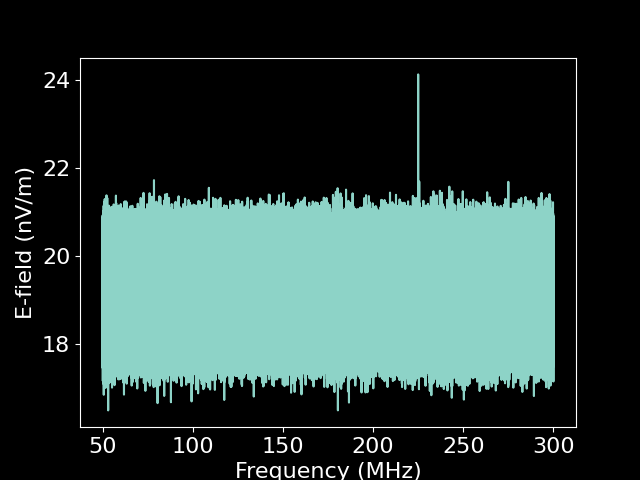

In [9]:
#overview plot 
#take mean and std from roach run 1 data. 
roachMeanPow = 1.5e-19 #W
roachStdPow = 1e-22 #W
print('################mean################')
P_lim = roachMeanPow
limCalc(P_lim, 5)


#hard code values from above
roachMeanE = 1.9170289512680815e-08 #V/m
roachStdE = 4.949747468305833e-10 #V/m

E_data = np.random.normal(roachMeanE, roachStdE, size=2**23)

nSigmaLim = E_data.mean() + 5 * E_data.std() 

#set a bin high to fake signal
E_data[int(2**23 * .7)] = E_data.mean() + 10* E_data.std() 

freqs = np.linspace(50, 300, 2**23)

plt.close('all')
plt.figure()
plt.plot(freqs, E_data/1e-9)
#plt.plot((freqs.min(), freqs.max()),(nSigmaLim/1e-9, nSigmaLim/1e-9), 'r')
#plt.plot((freqs.min(), freqs.max()),(nSigmaLim/1e-9, nSigmaLim/1e-9), 'r')
plt.xlabel('Frequency (MHz)')
plt.ylabel('E-field (nV/m)')


In [ ]:
#Compower AF plot

afDF = pd.read_csv('../../daqAnalysisAndExperiments/cstAndCompowerData/10m Compower AF-Table 1.csv')
#print(afDF.keys())
freqs = afDF['Freq., MHz']
afdB = afDF['Manufacturer, ComPower']
afLin = 10**(afdB/20)
print('mean AF = ', afLin.mean())

plt.close('all')
plt.figure()
plt.plot(freqs,afLin)
plt.title('Linear AF for Com-power AB-900A Bicon')
plt.ylabel('AF (1/m)')
plt.xlabel('Frequency (MHz)')
plt.tight_layout();


In [ ]:
P_lim = 1e-10

limCalc(P_lim, 7)



In [ ]:
#Setting a limit take 1, limit
#need to get power difference. This is linear! cant subtract dBm

P_thr = -75 #dBm
P_bg = -95 #dBm
AF = 5

powDiff = (10**(P_thr/10) - 10**(P_bg/10))/1000 #Watts
limCalc(powDiff, AF)

In [ ]:
myData = genData(sigFreqs = [123.456],
                     sigAmps = [0.09],
                     mean = 127,
                     std = 30,
                     numSamples = 2**18,
                     sampleRate = 600,
                     numAvg = 500)


myData.computePowAvg()


In [ ]:
powMean = myData.powAvg.mean()
powStd = myData.powAvg.std()
thresh = powMean + (5 * powStd)
print(np.log10(thresh))


plt.close('all')

plt.style.use('dark_background')
#plt.style.use('classic')


plt.figure()
plt.plot(myData.freqs, (myData.powAvg)/2e9)
#plt.plot([0, 300],([thresh, thresh]), 'r--')
plt.xlabel('Freqency (MHz)', fontsize = 17)
plt.ylabel('E-Field (\u03BCV/m))', fontsize = 17)

'''
fig1 = plt.figure(1)
difference = np.abs(myData.powAvg)
frame1=fig1.add_axes((.1,.3,.8,.6))
plt.plot(myData.freqs,difference, 'r', label = 'abs(comsol AF - cst AF)')
plt.legend()
plt.title('AF bicon in box (no res, galvanized steel, 1000 pts)')
plt.xlabel('Frequency [MHz]')
plt.ylabel('AF')
frame2=fig1.add_axes((.1,.1,.8,.2))        
plt.plot(myData.freqs, sps.zscore(myData.powAvg))
plt.plot([0, 300], [5,5])
#plt.plot(freq, af4, label = "comsol 20 log(mag(Ex/lpv)) + 5.6")
plt.legend()
'''

In [ ]:
freqs, power = np.load('./biconInRoom_1avg_0Gain_10kpts_RBW30kHz_30to300MHz_preampOff_0Att.npy')


print('mean = ', power.mean(), 'dBm')
print('std = ', power.std(), 'dBm')

mean = power.mean()
std = power.std()


plt.close('all')

plt.figure()

plt.plot(freqs/1e6, power)
plt.xlabel('Freq. (MHz)')
plt.ylabel('Power (dBm)')
plt.title('Bicon in Room')
#plt.plot((30,300), (mean + 1*std, mean + 1*std))
plt.tight_layout();


plt.figure()

plt.plot(freqs/1e6, 10**((power/10)) / 1000)
plt.xlabel('Freq. (MHz)')
plt.ylabel('Power (dBm)')
plt.title('Bicon in Room')
#plt.plot((30,300), (mean + 1*std, mean + 1*std))
plt.tight_layout();

print((power>(mean + std)).sum())


'''

plt.figure()
plt.hist(power, bins = 25);
plt.title('Bicon In Room')
'''


In [ ]:
limCalc(1e-12, 5)

In [ ]:
#take 3 add gain

freqsNoGain, powerNoGain = np.load('./biconInRoom_1avg_0Gain_10kpts_RBW30kHz_30to300MHz_preampOff_0Att.npy')
freqs, power = np.load('./biconInRoom_1avg_56dBGain_10kpts_RBW30kHz_30to300MHz_preampOff_0Att.npy')
freqs, gain= dr.getExtGain(freqsInterp = freqs, lengthMean = 5)

plt.close('all')

plt.figure()
plt.plot(freqsNoGain/1e6, powerNoGain)
plt.xlabel('Freq. (MHz)')
plt.ylabel('Power (dBm)')
plt.xlim(50, 300)
plt.title('$P_{meas}$')
plt.tight_layout();

plt.figure()
plt.plot(freqs/1e6, power)
plt.xlabel('Freq. (MHz)')
plt.ylabel('Power (dBm)')
plt.xlim(50, 300)
plt.title('$P_{meas, with \, gain}$')
plt.tight_layout();


plt.figure()
plt.plot(freqs/1e6, gain)
plt.xlabel('Freq. (MHz)')
plt.ylabel('Gain (dB)')
plt.xlim(50, 300)
plt.title('Gain of Amp Chain')
plt.tight_layout();

plt.figure()
plt.plot(freqs/1e6, power - gain)
plt.xlabel('Freq. (MHz)')
plt.ylabel('Power (dBm)')
plt.xlim(50, 300)
plt.title('$P_{meas}/G$')
plt.tight_layout();

#same plot, different title
plt.figure()
plt.plot(freqs/1e6, power - gain)
plt.xlabel('Freq. (MHz)')
plt.ylabel('Power (dBm)')
plt.xlim(50, 300)
plt.title('Bicon in Room, 56dB Gain, Corrected ')
plt.tight_layout();

In [ ]:
#take 3 limit 
plim = 10**(-118/10) / 1000

limCalc(plim, 5)

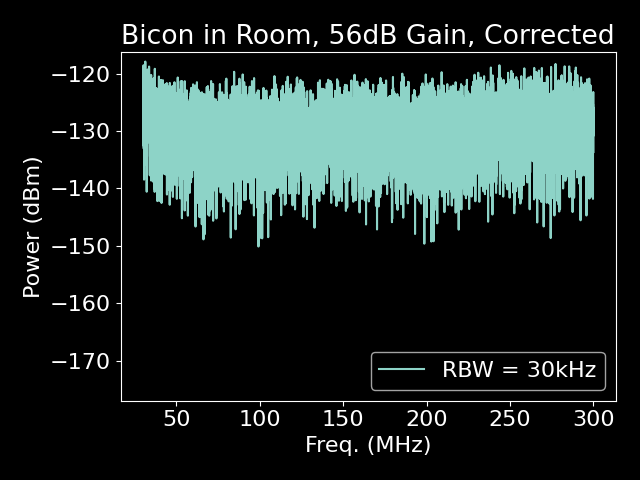

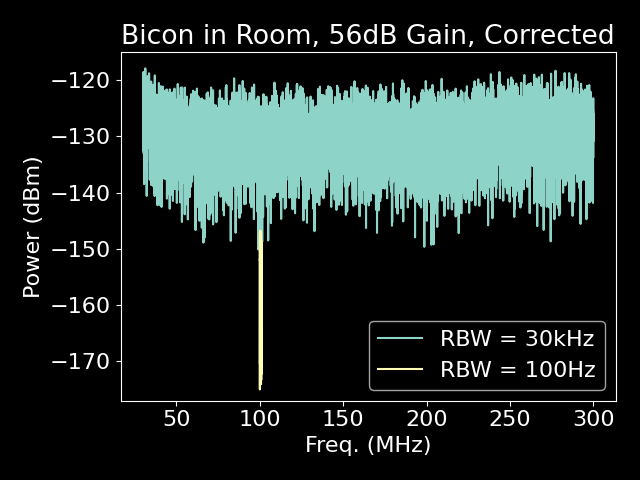

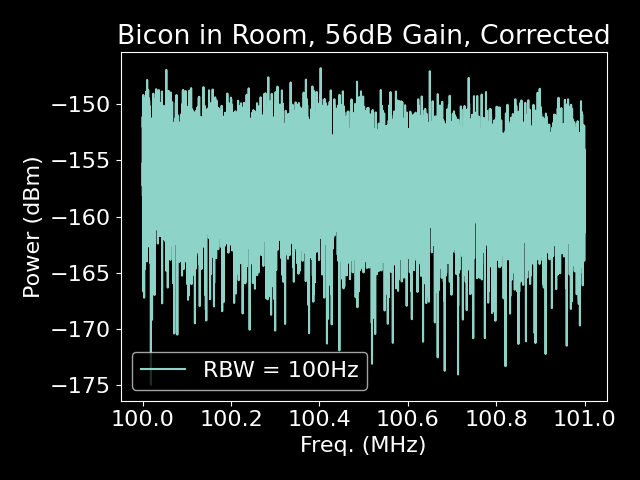

In [171]:
#take 3 thermal noise
freqsfull, powerfull = np.load('./biconInRoom_1avg_56dBGain_10kpts_RBW30kHz_30to300MHz_preampOff_0Att.npy')
freqsfull, gainfull= dr.getExtGain(freqsInterp = freqsfull, lengthMean = 5)

freqszoom, powerzoom = np.load('./biconInRoom_1avg_56dBGain_10kpts_RBW100Hz_100to101MHz_preampOff_0Att.npy')
freqszoom, gainzoom= dr.getExtGain(freqsInterp = freqszoom, lengthMean = 5)


plt.close('all')
plt.figure()

plt.plot(freqsfull/1e6, powerfull - gainfull, label = 'RBW = 30kHz')
plt.xlabel('Freq. (MHz)')
plt.ylabel('Power (dBm)')
plt.title('Bicon in Room, 56dB Gain, Corrected')
plt.legend(loc = 'lower right')
plt.ylim(-177)
plt.tight_layout();

plt.figure()
plt.plot(freqsfull/1e6, powerfull - gainfull, label = 'RBW = 30kHz')
plt.plot((freqszoom/1e6)[1:], powerzoom[1:] - gainzoom[1:], alpha = 1, label = 'RBW = 100Hz')
plt.xlabel('Freq. (MHz)')
plt.ylabel('Power (dBm)')
plt.title('Bicon in Room, 56dB Gain, Corrected')
plt.legend()
plt.ylim(-177)
plt.tight_layout();

plt.figure()
plt.plot((freqszoom/1e6)[1:], powerzoom[1:] - gainzoom[1:], alpha = 1, label = 'RBW = 100Hz')
plt.xlabel('Freq. (MHz)')
plt.ylabel('Power (dBm)')
plt.title('Bicon in Room, 56dB Gain, Corrected')
plt.legend()
plt.tight_layout();

In [5]:
#take 4 limit 
plim = 10**(-146/10) / 1000

limCalc(plim, 5)

AF =  5
P lim =  2.511886431509582e-18 W
V lim =  1.1206887238456498e-08 V
E lim =  5.603443619228249e-08 V/m
epsilon lim =  1.6980132179479544e-11


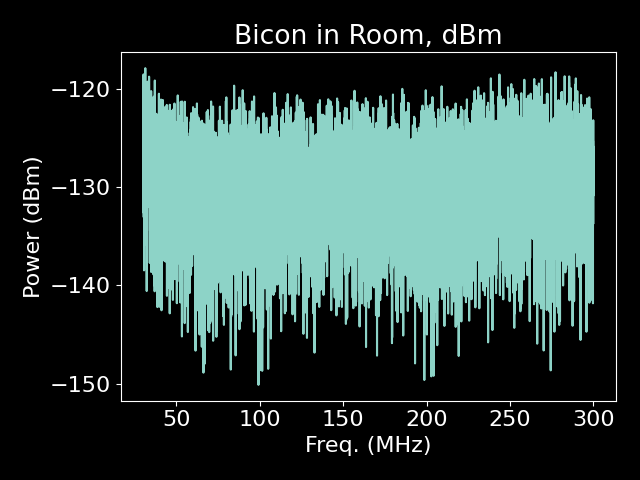

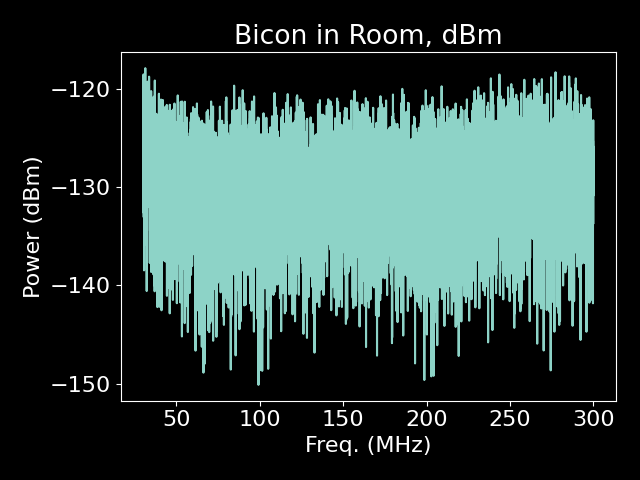

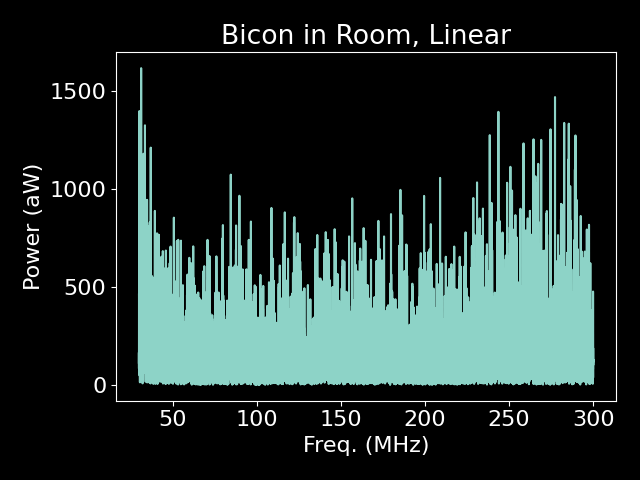

In [361]:
#take 5 averaging 
freqs, power = np.load('./biconInRoom_1avg_56dBGain_10kpts_RBW30kHz_30to300MHz_preampOff_0Att.npy')
freqs, power2avg = np.load('./biconInRoom_1avg_56dBGain_10kpts_RBW30kHz_30to300MHz_preampOff_0Att.npy')
freqs, gain= dr.getExtGain(freqsInterp = freqsfull, lengthMean = 5)




plt.close('all')

plt.figure()
plt.plot(freqs/1e6, power - gain, label = 'RBW = 30kHz')
plt.xlabel('Freq. (MHz)')
plt.ylabel('Power (dBm)')
plt.title('Bicon in Room, dBm')
#plt.legend(loc = 'lower right')
plt.tight_layout();

plt.figure()
plt.plot(freqs/1e6, power2avg - gain, label = 'RBW = 30kHz')
plt.xlabel('Freq. (MHz)')
plt.ylabel('Power (dBm)')
plt.title('Bicon in Room, dBm')
#plt.legend(loc = 'lower right')
plt.tight_layout();


plt.figure()
plt.plot(freqs/1e6, (10**((power - gain)/10))/1000 / 1e-18, label = 'RBW = 30kHz')
plt.xlabel('Freq. (MHz)')
plt.ylabel('Power (aW)')
plt.title('Bicon in Room, Linear')
#plt.legend(loc = 'lower right')
plt.tight_layout();



In [ ]:
#take 5 averaging 

freqs, power = np.load('./biconInRoom_1avg_56dBGain_10kpts_RBW100Hz_100to101MHz_preampOff_0Att.npy')
freqs, power = np.load('./')
freqs, gain= dr.getExtGain(freqsInterp = freqszoom, lengthMean = 5)


plt.close('all')

plt.figure()
plt.plot(freqszoom/1e6, powerzoom - gainzoom, label = 'RBW = 30kHz')
plt.xlabel('Freq. (MHz)')
plt.ylabel('Power (dBm)')
plt.title('Bicon in Room, dBm')
#plt.legend(loc = 'lower right')
plt.tight_layout();

In [ ]:
freqs, power = np.load('./biconInRoom_1avg_56dBGain_10kpts_RBW100Hz_100to101MHz_preampOff_0Att.npy')
freqs, gain= dr.getExtGain(freqsInterp = freqs)

linMean = 10**((power - gain)/10).mean()
linMeandBm = 10*np.log10(linMean)
print("mean of output referred power = ", (power - gain).mean())
print("lin mean of output referred power = ", linMeandBm)

k = 1.38e-23
temp = 350
rbw = 100
pJohnsondBm = 10 * np.log10(k * temp * rbw * 1000)

print('theoritical Johnson noise for', temp, 'K', 100, 'Hz RBW = ', pJohnsondBm )

print('remember impedance match of antenna!!')

plt.close('all')

plt.figure()
plt.plot(freqs/1e6, power)
plt.xlabel('Freq. (MHz)')
plt.ylabel('Power (dBm)')
plt.title('Input Referred Bicon in Room')

plt.figure()
plt.plot(freqs/1e6, gain)
plt.xlabel('Freq. (MHz)')
plt.ylabel('Power (dBm)')
plt.title('Gain of Amp Chain')

plt.figure()
plt.plot(freqs/1e6, power - gain)
plt.xlabel('Freq. (MHz)')
plt.ylabel('Power (dBm)')
plt.title('Output Referred Bicon in Room')


In [ ]:
freqs, power = np.load('./biconInRoom_1avg_56dBGain_10kpts_RBW100Hz_100to101MHz_preampOff_0Att.npy')
freqs, gain= dr.getExtGain(freqsInterp = freqs, lengthMean = 5)




plt.close('all')

plt.figure()
plt.plot(freqs/1e6, power)
plt.xlabel('Freq. (MHz)')
plt.ylabel('Power (dBm)')
plt.title('Input Referred Bicon in Room')

plt.figure()
plt.plot(freqs/1e6, gain)
plt.xlabel('Freq. (MHz)')
plt.ylabel('Power (dBm)')
plt.title('Gain of Amp Chain')

plt.figure()
plt.plot(freqs/1e6, power - gain)
plt.xlabel('Freq. (MHz)')
plt.ylabel('Power (dBm)')
plt.title('Output Referred Bicon in Room')

In [ ]:
#Amp chain gain for schamatic slide


measGain = dr.getExtGain()[1][1:]


plt.close('all')
plt.figure()
plt.plot(freqs[startFreqIdx:], measGain[startFreqIdx:], label = 'Measured gain + 20dB (ROACH internal)')
plt.title('Total Gain of Amp Chain')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Gain (dB)')


In [ ]:
#take 4 avg

freqs, power = np.load('./biconInRoom_1avg_56dBGain_10kpts_RBW30kHz_30to300MHz_preampOff_0Att.npy')
freqs, gain= dr.getExtGain(freqsInterp = freqs, lengthMean = 5)

plt.close('all')

plt.figure()
plt.plot(freqs/1e6, power - gain)
plt.xlabel('Freq. (MHz)')
plt.ylabel('Power (dBm)')
plt.title('Output Referred Bicon in Room')

In [198]:
#take 5 avg simulation 

import numpy as np
import matplotlib.pyplot as plt
import cupy

class genData:
    '''
    Inputs
    ------------------------
    sigFreqs: array-like
        Frequencies to generate signals. 
        [MHz] 
    sigAmps: array-like
        Amplitudes for signals. 
        Units linear and proportional to voltage, but arbitrary
        Must be same length as sigFreqs 
    mean: float
        mean value for noise
    std: float
        standard deviation of noise
    numSamples: float
        numbers of samples to capture. Twice as long as the fft
    sampleRate: float
        rate samples are captured 
        [MHz]
    numAvg: int
        number of averages to be computed using averaging methods
    
    
    Attributes
    ------------------------
    timeArr: np array
        array of times which signal is sampled by ADC
        [us]
    freqs: np array
        frequencies corosponding to bins of fft
        [MHz]
    
    '''
    def __init__(self,
            sigFreqs, 
            sigAmps,
            mean,
            std, 
            numSamples,
            sampleRate,
            numAvg):
        
        #check for valid args
        if len(sigFreqs) != len(sigAmps):
            raise ValueError('sigFreqs and sigAmps must be same length')
        
        #assign attributes to args
        self.sigFreqs = sigFreqs
        self.sigAmps = sigAmps
        self.mean = mean
        self.std = std
        self.numSamples = numSamples
        self.numAvg = numAvg
        
        #compute additional attributes
        self._halfNumSamples = self.numSamples//2
        self.sampleRate = sampleRate
        self.timeArr = cupy.asarray([i for i in range(0, self.numSamples)])/self.sampleRate
        self._signals = cupy.zeros(len(self.timeArr))
        for i in range(len(self.sigFreqs)):
            self._signals += self.sigAmps[i] * cupy.sin(2*cupy.pi * self.sigFreqs[i] * self.timeArr)
        self.freqs = np.linspace(0, self.sampleRate//2, self.numSamples//2)[1:]
        self.genTimeDataGpu()
        
        '''
        ###Testing 8bit###
        self._signals = np.zeros(len(self.timeArr), dtype = np. int8)
        for i in range(len(self.sigFreqs)):
            self._signals += np.rint(self.sigAmps[i] * np.sin(2*np.pi * self.sigFreqs[i] * self.timeArr))
        '''
        
    def genTimeData(self):
        '''
        Seperates all math which relies on random noise. 
        Ran everytime new data is 'acquired', so slightly optimized
        '''
        noiseData = np.random.normal(self.mean, self.std, size=self.numSamples)
        self.timeData = noiseData + self._signals
        
        #throw out DC and second half of fft from imaginary part 
        self.fft = np.abs(np.fft.fft(self.timeData)[1:(self._halfNumSamples)])  
        
        self.powSpec = 2*(self.fft**2)/(self.numSamples**2 * 50)
        
        #uncomment to save powSpec in dB. about 20ms/call for 2**24 pt fft
        #self.powSpecdB = 10*np.log10(self.powSpec)
        
    def genTimeDataGpu(self):
        '''
        Seperates all math which relies on random noise. 
        Ran everytime new data is 'acquired', so slightly optimized
        '''
        noiseData = cupy.random.normal(self.mean, self.std, size=self.numSamples)
        self.timeData = (noiseData + self._signals)
        
        #throw out DC and second half of fft from imaginary part 
        self.fft = cupy.abs(cupy.fft.fft(self.timeData)[1:(self._halfNumSamples)])  
        
        self.powSpec = cupy.asarray(2*self.fft**2/(self.numSamples**2 * 50))
        
        #uncomment to save powSpec in dB. about 20ms/call for 2**24 pt fft
        #self.powSpecdB = 10*np.log10(self.powSpec)
        
    def genTimeData8Bit(self):
        noiseData = np.asarray(
            np.rint(np.random.normal(mean, std, 2**24)), dtype = np. int8)
        self.timeData = noiseData + self._signals
        
        #throw out DC and second half of fft from imaginary part 
        self.fft = np.abs(np.fft.fft(self.timeData)[1:(self._halfNumSamples)])  
        
        self.powSpec = 2*self.fft**2
        
        #uncomment to save powSpec in dB. about 20ms/call for 2**24 pt fft
        #self.powSpecdB = 10*np.log10(self.powSpec)

        
    def computePowAvg(self):
        self.powAvg = cupy.asarray(self.powSpec)
        for i in range(1, self.numAvg):
            #print(i)
            self.genTimeDataGpu()
            self.powAvg = self.powAvg * (i-1)/i + self.powSpec/i

    def setNumAvg(self, numAvg):
        self.numAvg = numAvg


roomTemp = 300

NF = 1
ampTemp = 290  * (10**(NF/10) - 1)
sysTemp = ampTemp + roomTemp
print('System temp = ', round(sysTemp, 2), 'K')

kb = 1.380649e-23 #J/K
deltaNu = 35 #Hz

thermalNoiseDens = kb * sysTemp 

thermalNoiseDens_dBm = 10*np.log10(thermalNoiseDens * 1000)
thermalBg_dBm = 10*np.log10(thermalNoiseDens * deltaNu * 1000)

print('total thermal background = ', round(thermalNoiseDens_dBm, 2), 'dBm per Hz')
print('total thermal background = ', round(thermalBg_dBm, 2), 'dBm per bin')

def dBm2linPow(dBm):
    return(10**((dBm - 30) /10))

print('thermal background = ', dBm2linPow(thermalBg_dBm), 'W per bin')

numAvg = 1*np.sqrt(2)

System temp =  375.09 K
total thermal background =  -172.86 dBm per Hz
total thermal background =  -157.42 dBm per bin
thermal background =  1.8125288375312317e-19 W per bin


In [242]:
sigFreqs = [.6790379]
mean = 0
numSamples = 2**14
sampleRate = 2 #MHz
numAvg = 2


roomTemp = 250
NF = 1
ampTemp = 290  * (10**(NF/10) - 1)
sysTemp = ampTemp + roomTemp
print('System temp = ', round(sysTemp, 2), 'K')

kb = 1.380649e-23 #J/K
deltaNu = sampleRate * 1e6 / numSamples

thermalNoiseDens = kb * sysTemp 

thermalNoiseDens_dBm = 10*np.log10(thermalNoiseDens * 1000)
thermalBg_dBm = 10*np.log10(thermalNoiseDens * deltaNu * 1000)

print('total thermal background = ', round(thermalNoiseDens_dBm, 2), 'dBm per Hz')
print('total thermal background = ', round(thermalBg_dBm, 2), 'dBm per bin')
print('bin width = ', deltaNu, 'Hz')

def dBm2linPow(dBm):
    return(10**((dBm - 30) /10))

print('thermal background = ', dBm2linPow(thermalBg_dBm), 'W per bin')

std = np.sqrt(thermalNoiseDens * (sampleRate * 1e6 / 2) * 50)
#std = 0
print('noise voltage = ', std, 'V')
stdTherm = 4.46e-10* 1.73e4 


powerMultplier = 0 #linear multplier of sig power above noise


voltageMultplier = (2*powerMultplier)**0.5 #2 is for p2p
sigAmps = [np.sqrt(thermalNoiseDens * deltaNu * 50) * (voltageMultplier)]
#sigAmps = [5 * 0.707 * 2]
#sigAmps = [1**2 / 2]

if sigAmps[0]:
    print('\n##################Injected signal stuff###################')
    print('injected signal = ', sigAmps[0] * 2, 'Volts p2p')
    print('injected signal = ', 10* np.log10((sigAmps[0]*0.707)**2/50 * 1000), 'dBm')
    print('injected signal = ', (sigAmps[0]*0.707)**2/50, 'Watts')
    measMaxPow = genData(sigFreqs,sigAmps,mean,0,numSamples,sampleRate,numAvg).powSpec.get().max()
    print('Measured injected signal =', measMaxPow, 'Watts')
    print('Measured injected signal =', 10*np.log10(measMaxPow*1000), 'dBm')

myData = genData(sigFreqs,sigAmps,mean,std,numSamples,sampleRate,numAvg)

myData.computePowAvg();

System temp =  325.09 K
total thermal background =  -173.48 dBm per Hz
total thermal background =  -152.61 dBm per bin
bin width =  122.0703125 Hz
thermal background =  5.478917628805896e-19 W per bin
noise voltage =  4.737261509309886e-07 V


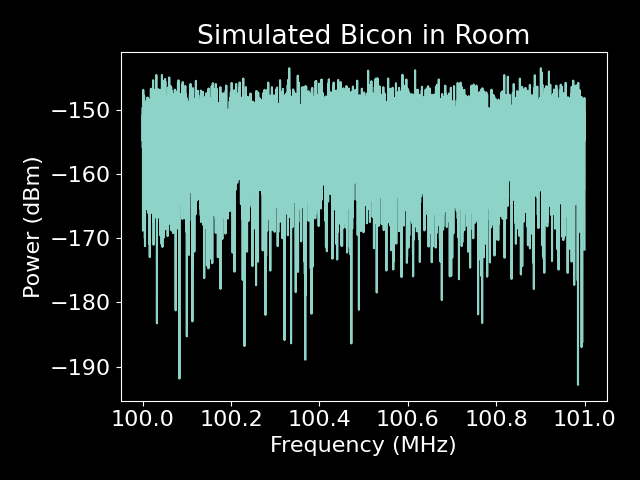

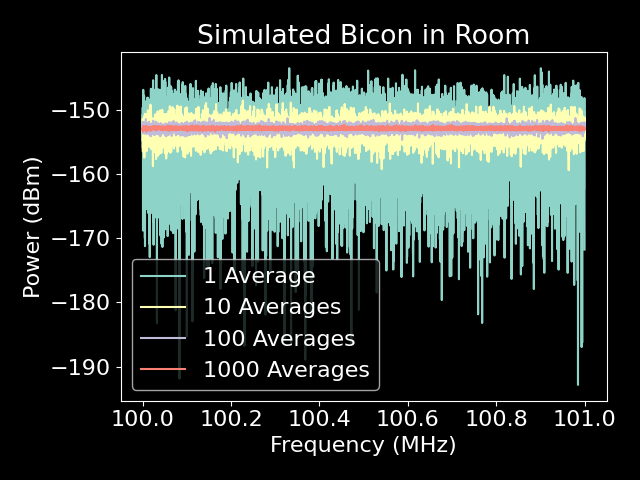

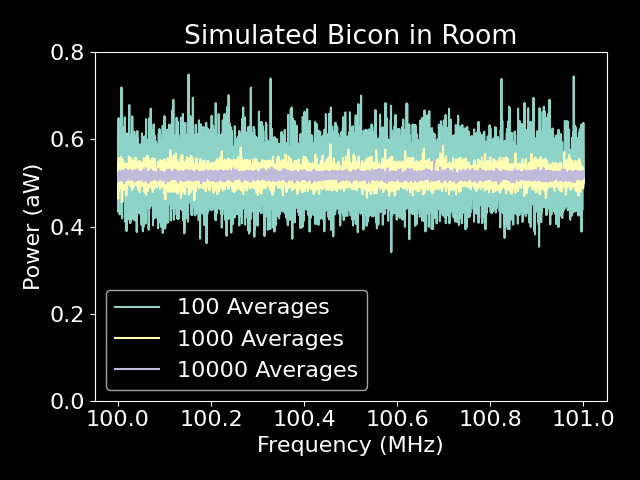

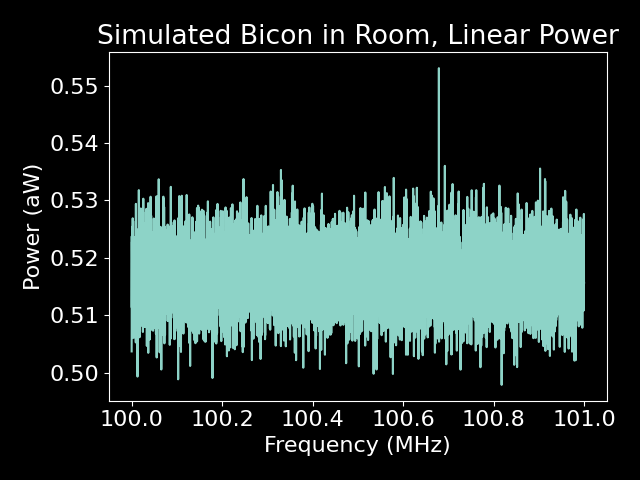

In [277]:
#take 5 Averaging
myData.setNumAvg(1)
myData.computePowAvg()
powAvg1 = myData.powAvg.get()

myData.setNumAvg(10)
myData.computePowAvg()
powAvg10 = myData.powAvg.get()

myData.setNumAvg(100)
myData.computePowAvg()
powAvg100 = myData.powAvg.get()

myData.setNumAvg(1000)
myData.computePowAvg()
powAvg1000 = myData.powAvg.get()

myData.setNumAvg(10000)
myData.computePowAvg()
powAvg10000 = myData.powAvg.get()

freqShift = 100 #MHz
powAvg = myData.powAvg.get()

plt.close('all')

plt.figure()
plt.title('Simulated Bicon in Room')
plt.plot(myData.freqs + freqShift, 10*np.log10(powAvg1 * 1000))
plt.xlabel('Frequency (MHz)')
plt.ylabel('Power (dBm)')
plt.tight_layout();

plt.figure()
plt.title('Simulated Bicon in Room')
plt.plot(myData.freqs + freqShift, 10*np.log10(powAvg1 * 1000), label = '1 Average')
plt.plot(myData.freqs + freqShift, 10*np.log10(powAvg10 * 1000), label = '10 Averages')
plt.plot(myData.freqs + freqShift, 10*np.log10(powAvg100 * 1000), label = '100 Averages')
plt.plot(myData.freqs + freqShift, 10*np.log10(powAvg1000 * 1000), label = '1000 Averages')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Power (dBm)')
plt.legend()
plt.tight_layout();

plt.figure()
plt.title('Simulated Bicon in Room')
#plt.plot(myData.freqs + freqShift, powAvg1/1e-18, label = '1 Average')
#plt.plot(myData.freqs + freqShift, powAvg10/1e-18, label = '10 Averages')
plt.plot(myData.freqs + freqShift, powAvg100/1e-18, label = '100 Averages')
plt.plot(myData.freqs + freqShift, powAvg1000/1e-18, label = '1000 Averages')
plt.plot(myData.freqs + freqShift, powAvg10000/1e-18, label = '10000 Averages')
plt.ylim(0, .8)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Power (aW)')
plt.legend()
plt.tight_layout();


plt.figure()
plt.title('Simulated Bicon in Room, Linear Power')
plt.plot(myData.freqs + freqShift, powAvg/ 1e-18)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Power (aW)')
plt.tight_layout();




In [7]:
#take 5 averaging setting a limit

sigFreqs = [.6790379]
mean = 0
numSamples = 2**14
sampleRate = 2 #MHz
numAvg = 50000


roomTemp = 300
NF = .1
ampTemp = 290  * (10**(NF/10) - 1)
sysTemp = ampTemp + roomTemp
print('System temp = ', round(sysTemp, 2), 'K')

kb = 1.380649e-23 #J/K
deltaNu = sampleRate * 1e6 / numSamples

thermalNoiseDens = kb * sysTemp 

thermalNoiseDens_dBm = 10*np.log10(thermalNoiseDens * 1000)
thermalBg_dBm = 10*np.log10(thermalNoiseDens * deltaNu * 1000)

print('total thermal background = ', round(thermalNoiseDens_dBm, 2), 'dBm per Hz')
print('total thermal background = ', round(thermalBg_dBm, 2), 'dBm per bin')
print('bin width = ', deltaNu, 'Hz')

def dBm2linPow(dBm):
    return(10**((dBm - 30) /10))

print('thermal background = ', dBm2linPow(thermalBg_dBm), 'W per bin')

std = np.sqrt(thermalNoiseDens * (sampleRate * 1e6 / 2) * 50)
#std = 0
print('noise voltage = ', std, 'V')
stdTherm = 4.46e-10* 1.73e4 


powerMultplier = .08481 #linear multplier of sig power above noise
#powerMultplier = 0

voltageMultplier = (2*powerMultplier)**0.5 #2 is for p2p
sigAmps = [np.sqrt(thermalNoiseDens * deltaNu * 50) * (voltageMultplier)]
#sigAmps = [5 * 0.707 * 2]
#sigAmps = [1**2 / 2]

if sigAmps[0]:
    print('\n##################Injected signal stuff###################')
    print('injected signal = ', sigAmps[0] * 2, 'Volts p2p')
    print('injected signal = ', 10* np.log10((sigAmps[0]*0.707)**2/50 * 1000), 'dBm')
    print('injected signal = ', (sigAmps[0]*0.707)**2/50, 'Watts')
    measMaxPow = genData(sigFreqs,sigAmps,mean,0,numSamples,sampleRate,numAvg).powSpec.get().max()
    print('Measured injected signal =', measMaxPow, 'Watts')
    print('Measured injected signal =', 10*np.log10(measMaxPow*1000), 'dBm')

myData = genData(sigFreqs,sigAmps,mean,std,numSamples,sampleRate,numAvg)

myData.computePowAvg();
%matplotlib widget 

powAvg = myData.powAvg.get()
powAvgMean = np.median(powAvg) #median to not bias for large signal
powAvgStd = powAvg[0:numSamples//4].std() #only take first half to avoid .678MHz signal
numSigma = 5
powAvgLim = powAvgMean + (numSigma * powAvgStd)

#limit = (powAvgMean - numSigma * powAvgStd)
# limit = powAvgMean - (powAvgLim/powAvgMean) * powAvgMean 
limit =  numSigma * powAvgStd
print('limit = ', limit, 'W')

#limitSquare = powAvgMean - (powAvgLim/powAvgMean)**2 * powAvgMean 
limitSquare = powAvgMean - ((powAvgMean + powAvgStd)/powAvgMean)**2 * powAvgMean 


print('limit (square) = ', limitSquare, 'W')

numCandidates = (powAvg > powAvgLim).sum()
print('Number of candidates = ',numCandidates)


dBmPowAvgMean = 10 * np.log10(powAvgMean * 1000)
dBmPowAvgLim = 10 * np.log10(powAvgLim * 1000)

print('computed mean power = ', round(10*np.log10(powAvg.mean()*1000), 5), 'dBm')
print('expected mean power = ', round(thermalBg_dBm,5), 'dBm')

freqShift = 100 #MHz
plt.close('all')
'''
plt.figure()
plt.title('Power dBm,  %i Averages' % numAvg )
plt.plot(myData.freqs + freqShift, 10*np.log10(powAvg*1000), 
        label = '2^%i point FFT ' % int(np.log2(numSamples)))
#plt.plot((freqShift,sampleRate/2 + freqShift),
#    (dBmPowAvgMean, dBmPowAvgMean), label= 'Mean')
plt.plot((freqShift,sampleRate/2 + freqShift),(dBmPowAvgLim, dBmPowAvgLim), 
        '--', label = '%f sigma limit' % numSigma)
plt.plot(sigFreqs[0] + freqShift, 10* np.log10(measMaxPow * 1000),
     'ro', label = 'Meas Injected Signal')
plt.plot((freqShift, sampleRate/2 + freqShift),
        (10*np.log10(limit*1000), 10*np.log10(limit*1000)), 
        '--', label= 'Limit')
plt.fill_between((freqShift, sampleRate/2 + freqShift),
        (10*np.log10((limit + powAvgStd)*1000) , 
        10*np.log10((limit + powAvgStd)*1000)),
        (10*np.log10((limit-powAvgStd)*1000),
         10*np.log10((limit-powAvgStd)*1000)),
         alpha = .5,
         label = '1 sigma limit uncertainty')
#plt.plot((freqShift, sampleRate/2 + freqShift),
        #(10*np.log10(limitSquare*1000), 10*np.log10(limitSquare*1000)), 
        #'--', label= 'Limit^2')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Power (dBm)')
plt.legend()

plt.figure()
plt.title('Power dBm,  %i Averages' % numAvg )
plt.plot(myData.freqs + freqShift, 10*np.log10(powAvg*1000), 
        label = '2^%i point FFT ' % int(np.log2(numSamples)))
#plt.plot((freqShift,sampleRate/2 + freqShift),
#    (dBmPowAvgMean, dBmPowAvgMean), label= 'Mean')
plt.plot((freqShift,sampleRate/2 + freqShift),(dBmPowAvgLim, dBmPowAvgLim), 
        '--', label = '%f sigma limit' % numSigma)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Power (dBm)')
plt.legend()
'''
#just data
plt.figure()
plt.title('Linear Power, %i Averages' % numAvg)
plt.plot(myData.freqs + freqShift, powAvg/1e-18)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Power (aW)');
plt.ylim(0,.8)
plt.tight_layout();
plt.savefig('../take5Pix/justData.png', dpi = 600)


#data and 5 sigma
plt.figure()
plt.title('Linear Power, %i Averages' % numAvg)
plt.plot(myData.freqs + freqShift, powAvg/1e-18)
plt.plot((freqShift,sampleRate/2 + freqShift),(powAvgLim/1e-18, powAvgLim/1e-18), \
        '--', label = '5$\sigma$ limit')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Power (aW)');
plt.ylim(0,.8)
plt.legend();
plt.tight_layout();
plt.savefig('../take5Pix/5sigma.png', dpi = 600)

#data, 5 sigma and detection thresh
plt.figure()
plt.title('Linear Power, %i Averages' % numAvg)
plt.plot(myData.freqs + freqShift, powAvg/1e-18)
plt.plot((freqShift,sampleRate/2 + freqShift),(powAvgLim/1e-18, powAvgLim/1e-18), \
        '--', label = '5$\sigma$ limit')
plt.plot((freqShift, sampleRate/2 + freqShift),(limit/1e-18, limit/1e-18),\
         '--', label= 'Detection Threshold')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Power (aW)');
plt.ylim(0,.8)
plt.legend();
plt.tight_layout();
plt.savefig('../take5Pix/5sigmaAndThresh.png', dpi = 600)

#data, 5 sigma and detection thresh and signal
plt.figure()
plt.title('Linear Power, %i Averages' % numAvg)
plt.plot(myData.freqs + freqShift, powAvg/1e-18)
plt.plot((freqShift,sampleRate/2 + freqShift),(powAvgLim/1e-18, powAvgLim/1e-18), \
        '--', label = '5$\sigma$ limit')
plt.plot((freqShift, sampleRate/2 + freqShift),(limit/1e-18, limit/1e-18),\
         '--', label= 'Detection Threshold')
plt.plot(sigFreqs[0] + freqShift, measMaxPow/1e-18, \
     'ro', label = 'Injected Signal')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Power (aW)');
plt.ylim(0,.8)
plt.legend(loc = 'lower left');
plt.tight_layout();
plt.savefig('../take5Pix/5sigmaThreshAndSig.png', dpi = 600)

#data and 5 sigma zoom
plt.figure()
plt.title('Linear Power, %i Averages' % numAvg)
plt.plot(myData.freqs + freqShift, powAvg/1e-18)
plt.plot((freqShift,sampleRate/2 + freqShift),(powAvgLim/1e-18, powAvgLim/1e-18), \
        '--', label = '5$\sigma$ limit')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Power (aW)');
plt.legend();
plt.tight_layout();
plt.savefig('../take5Pix/5sigmaZoom.png', dpi = 600)




System temp =  306.75 K
total thermal background =  -173.73 dBm per Hz
total thermal background =  -152.87 dBm per bin
bin width =  122.0703125 Hz
thermal background =  5.169933343320756e-19 W per bin
noise voltage =  4.6017439057646126e-07 V

##################Injected signal stuff###################
injected signal =  4.187897070592982e-09 Volts p2p
injected signal =  -163.58199169822964 dBm
injected signal =  4.383296313088841e-20 Watts


AttributeError: 'numpy.ndarray' object has no attribute 'get'

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


AF =  5
P lim =  1.1681059261057613e-19 W
V lim =  2.416718773570646e-09 V
E lim =  1.2083593867853229e-08 V/m
epsilon lim =  3.6616951114706756e-12


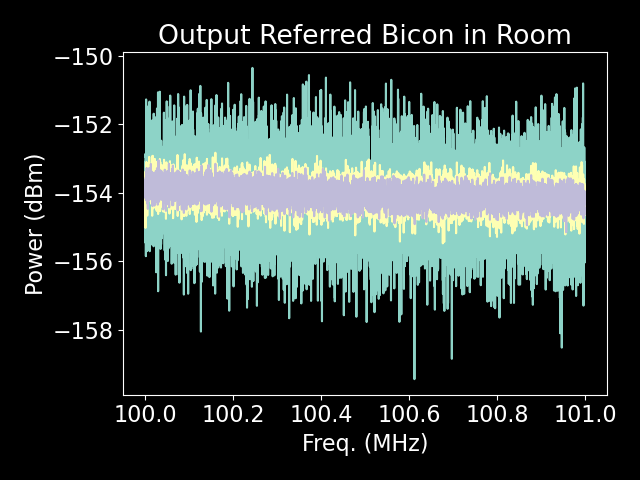

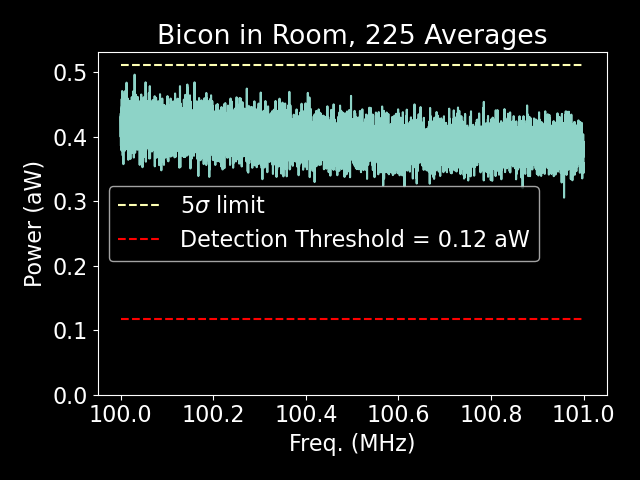

In [4]:
#take 5 avg, set lim

freqs = np.linspace(100e6, 101e6, 10000)

freqswrong, power10avg = np.load('./biconInRoom_10avg_56dBGain_10kpts_RBW100_100to101MHz_preampOff_0Att_10_18_22.npy')
freqswrong, power101avg = np.load('./biconInRoom_101avg_56dBGain_10kpts_RBW100_100to101MHz_preampOff_0Att_10_18_22.npy')
freqswrong, power225avg = np.load('./biconInRoom_225avg_56dBGain_10kpts_RBW100_100to101MHz_preampOff_0Att_10_18_22.npy')
freqs, gain= dr.getExtGain(freqsInterp = freqs, lengthMean = 5)

#fake it to match simulation
power10avg += 4
power101avg += 4
power225avg += 4

P_lim = (10**((power225avg - gain)/10) / 1000).std() * 5
P_mean = (10**((power225avg - gain)/10) / 1000).mean()
fiveSigmaLim = P_mean + P_lim
limCalc(P_lim, 5)


plt.close('all')

plt.figure()
plt.plot(freqs/1e6, power10avg - gain)
plt.plot(freqs/1e6, power101avg - gain)
plt.plot(freqs/1e6, power225avg - gain)
plt.xlabel('Freq. (MHz)')
plt.ylabel('Power (dBm)')
plt.title('Output Referred Bicon in Room')
plt.tight_layout();


plt.figure()
#plt.plot(freqs/1e6, 10**((power10avg - gain)/10) /1000 / 1e-18)
#plt.plot(freqs/1e6, 10**((power101avg- gain)/10) / 1000 / 1e-18)
plt.plot(freqs/1e6, 10**((power225avg - gain)/10) / 1000 / 1e-18)
plt.plot((100,101),( fiveSigmaLim/1e-18, fiveSigmaLim/1e-18),\
        '--', label = '5$\sigma$ limit')
plt.plot((100, 101),(P_lim/1e-18, P_lim/1e-18),\
         'r--', label= 'Detection Threshold = 0.12 aW')
plt.ylim(0)
plt.plot(())
plt.xlabel('Freq. (MHz)')
plt.ylabel('Power (aW)')
plt.title('Bicon in Room, 225 Averages')
plt.legend(loc = 'center left')

plt.tight_layout();

/tmp/ipykernel_2521779/1230493839.py:29: RuntimeWarning: divide by zero encountered in power
  return (x**((1/2)-1) * np.exp(-x/2)) / (2**(1/2) * np.sqrt(np.pi))


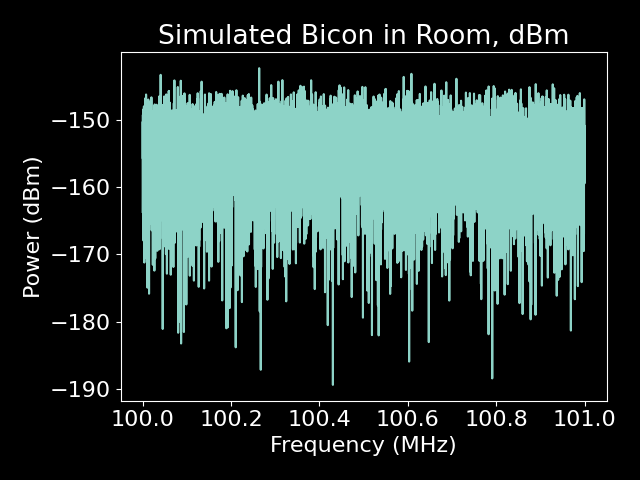

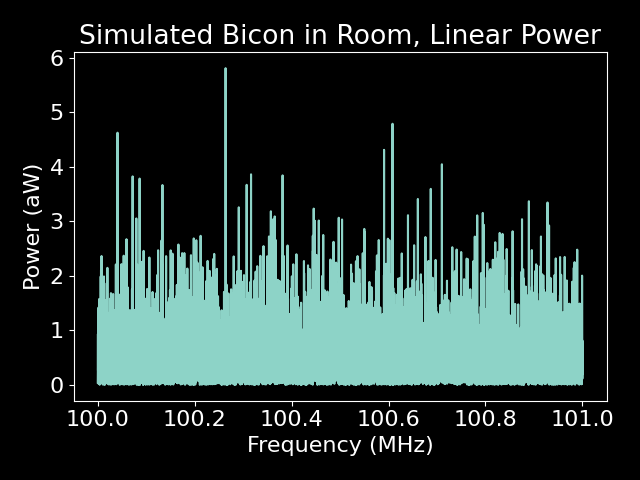

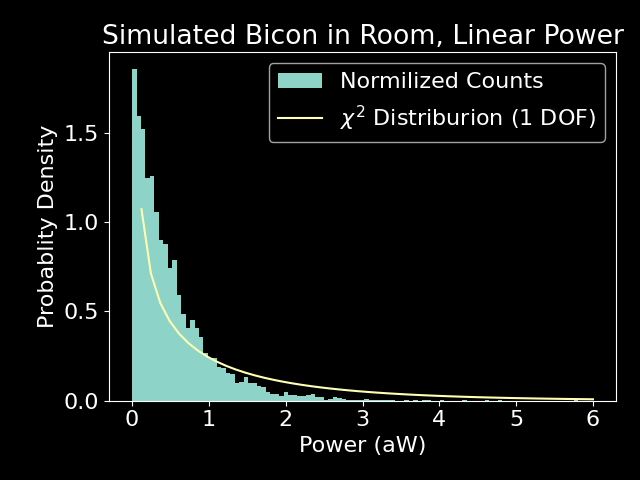

In [290]:
#take 5 Averaging Extra slide
myData.setNumAvg(1)
myData.computePowAvg()

freqShift = 100 #MHz
powAvg = myData.powAvg.get()

plt.close('all')

plt.figure()
plt.title('Simulated Bicon in Room, dBm')
plt.plot(myData.freqs + freqShift, 10*np.log10(powAvg * 1000))
plt.xlabel('Frequency (MHz)')
plt.ylabel('Power (dBm)')
plt.tight_layout();


plt.figure()
plt.title('Simulated Bicon in Room, Linear Power')
plt.plot(myData.freqs + freqShift, powAvg/ 1e-18)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Power (aW)')
plt.tight_layout();


chi2xVals = np.linspace(0, 6)
def chi2(x):
    #assumes 1 DOF
    return (x**((1/2)-1) * np.exp(-x/2)) / (2**(1/2) * np.sqrt(np.pi))

plt.figure()
plt.title('Simulated Bicon in Room, Linear Power')
plt.hist(powAvg/ 1e-18, bins = 100, density=True, label = 'Normilized Counts')
plt.xlabel('Power (aW)')
plt.ylabel('Probablity Density')
plt.plot(chi2xVals, chi2(chi2xVals), label = '$\chi^2$ Distriburion (1 DOF)' )
plt.legend()
plt.tight_layout();

In [13]:
#ROACH
freqs = np.load('../../daqAnalysisAndExperiments/run1Analysis/run1_freqData_avgAll11776Spectra_gitignore.npy')
antData = np.load('../../daqAnalysisAndExperiments/run1Analysis/run1_antData_avgAll11776Spectra_gitignore.npy')[1:]
termData = np.load('../../daqAnalysisAndExperiments/run1Analysis/run1_termData_avgAll11776Spectra_gitignore.npy')[1:]

1398101


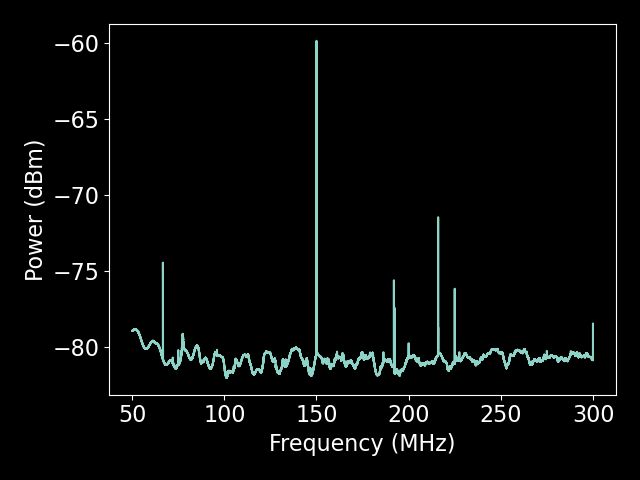

In [14]:
startFreq = 50 #Mhz
startFreqIdx = int(startFreq/300 * len(freqs))
print(startFreqIdx)

plt.close('all')
plt.figure()
plt.plot(freqs[startFreqIdx:], dr.fft2dBm(antData[startFreqIdx:]), label = 'Bicon')
#plt.plot(freqs[startFreqIdx:], dr.fft2dBm(termData[startFreqIdx:]), label = 'Terminator')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Power (dBm)')
#plt.legend(loc = 'upper right')
plt.tight_layout();

System temp =  375.0883694203085
total thermal background in dBm =  -157.32351661387784


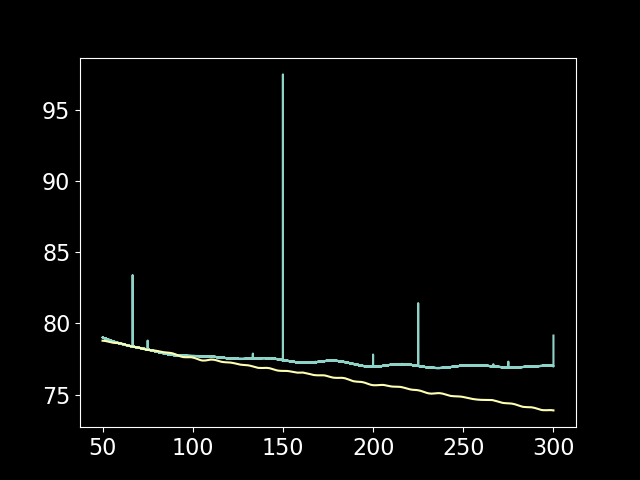

In [15]:
roomTemp = 300

NF = 1
ampTemp = 290  * (10**(NF/10) - 1)
sysTemp = ampTemp + roomTemp
print('System temp = ', sysTemp)

kb = 1.380649e-23 #J/K
deltaNu = (freqs[1] - freqs[0]) * 1e6 #Hz

thermalNoiseDens = kb * sysTemp 
thermalBg_dBm = 10*np.log10(thermalNoiseDens * deltaNu * 1000)
print('total thermal background in dBm = ', thermalBg_dBm)


selfGain = dr.fft2dBm(termData[startFreqIdx:]) - thermalBg_dBm 


measGain = dr.getExtGain()[1][1:]


plt.close('all')
plt.figure()
plt.plot(freqs[startFreqIdx:], selfGain, label = 'Gain assuming johnson + (NF = %f)' % round(NF, 1))
plt.plot(freqs[startFreqIdx:], measGain[startFreqIdx:] + 20.8, label = 'Measured gain + 20dB (ROACH internal)')
#plt.legend(loc = 'upper right')



Text(0, 0.5, 'Power(aW)')

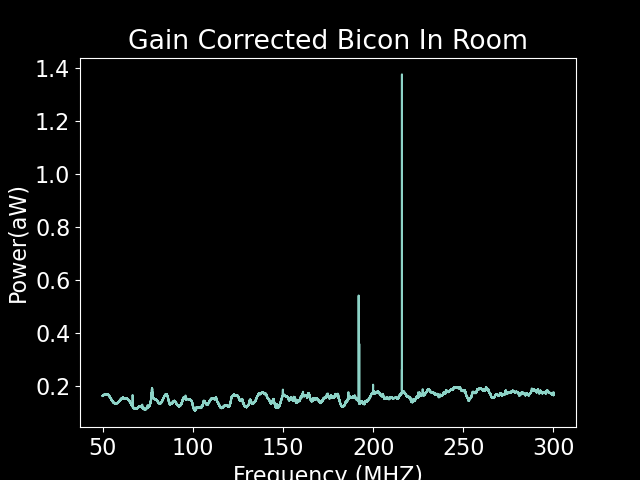

In [20]:
dataCorrecteddBm = dr.fft2dBm(antData[startFreqIdx:]) - selfGain
dataCorrectedLin = (10**(dataCorrecteddBm/10)) / 1000

plt.close('all')
plt.figure()
plt.plot(freqs[startFreqIdx:], dataCorrectedLin/1e-18, label = 'Bicon, self gain correction')
#plt.plot(freqs[startFreqIdx:], dr.fft2dBm(antData[startFreqIdx:]) - measGain[startFreqIdx:] - 20.8 , label = 'Bicon, Measured gain correction')
plt.title('Gain Corrected Bicon In Room')
#plt.legend(loc = 'upper right')
plt.xlabel('Frequency (MHZ)')
plt.ylabel('Power(aW)')

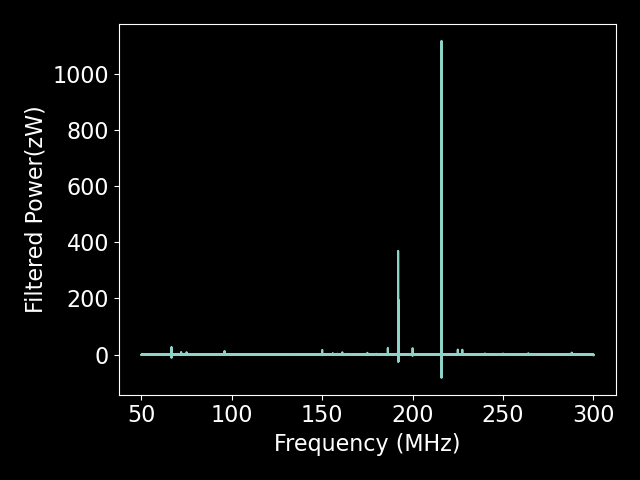

In [21]:
from scipy import signal

# Sampling rate such that the total amount of data is 1s
fs = len(antData)

# Cutoff in number of bins
fc = 30

# Normalize the frequency in term of Nyquist
fcNorm = 2./(fc)

# Create a 6th-order Butterworth filter - returns numerator (b) and denominator (a) polynomials of the IIR filter
b, a = signal.butter(6, fcNorm, 'highpass', analog = False)


# Apply the Butterworth filter to the acquired data that has been corrected for the 
# noise power of the amplifiers and the gain of the amplifiers
filteredData = signal.filtfilt(b, a, dataCorrectedLin[:])

plt.close('all')
plt.figure()
plt.plot((freqs[startFreqIdx:]), (filteredData)/1e-21)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Filtered Power(zW)')
plt.tight_layout()
plt.show()

In [3]:
P_lim = 0.4e-21 #watts
#P_lim = 10**(-173.73/10) / 1000 * 100
  
limCalc(P_lim, 5)

AF =  5
P lim =  4e-22 W
V lim =  1.414213562373095e-10 V
E lim =  7.071067811865476e-10 V/m
epsilon lim =  2.1427478217774169e-13


In [ ]:
import numpy as np
import nnAudio as nna
import cupy as cp

lenFFT = 2**24
noiseData = np.random.normal(0, 1, lenFFT)  
noiseDataGPU = cp.random.normal(0, 1, lenFFT)       
 
        

In [ ]:
%%timeit
fft = np.abs(np.fft.fft(noiseData)[1:(lenFFT)]) 

In [ ]:
%%timeit
fft = cp.abs(cp.fft.fft(noiseDataGPU)[1:(lenFFT)])